# QRt: QR Code Art Generator

This project is a part of the elective course on Generative Artificial Intelligence at Innopolis University.

It is a collaborative effort by our team members:

- Polina Zelenskaya, p.zelenskaya@innopolis.university
- Leila Khaertdinova, l.khaertdinova@innopolis.university
- Karina Denisova, k.denisova@innopolis.university
---
This notebook is a sandbox for testing hypotheses and proving concept of our ideas. The code provided below was designed to run in a cuda-compatable environment with at least 16GB of available memory on the Ubuntu system. For that reason, collab with the `T4 GPU` works perfectly.

## Required setups

In [ ]:
!sudo apt-get install zbar-tools
!pip install git+https://github.com/huggingface/diffusers accelerate transformers==4.30.0 qrcode pyzbar
!pip install -q gradio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common libdjvulibre-text libdjvulibre21 libfftw3-double3
  libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libjxr-tools libjxr0
  liblqr-1-0 libmagickcore-6.q16-6 libmagickcore-6.q16-6-extra
  libmagickwand-6.q16-6 libv4l-0 libv4lconvert0 libwmflite-0.2-7 libzbar0
  poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x libfftw3-bin libfftw3-dev inkscape poppler-utils
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum
  zbarcam-gtk zbarcam-qt
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common libdjv

In [ ]:
import qrcode
from PIL import Image
from pyzbar.pyzbar import decode
import torch
import transformers
from diffusers import UniPCMultistepScheduler
from diffusers import DPMSolverMultistepScheduler
from diffusers import ControlNetModel
from diffusers import StableDiffusionControlNetPipeline
from diffusers import UniPCMultistepScheduler
import gradio

## Create a simple QR-code generator for a text/link

In [ ]:
class BasicQR:
    """
    Main class to read/generate basic (target) QR-codes that are readable by any device
    """

    @staticmethod
    def generate(text: str, box_size: int = 10, border: int = 4) -> Image:
        """
        Generates valid qr-code for a given `text`
            > QR version is determined automatically
            > Error correction is at minimal (for smaller image sizes)
            > Black/white colors is used
        """

        # define generator
        qr = qrcode.QRCode(
            error_correction=qrcode.constants.ERROR_CORRECT_L,
            box_size=box_size,
            border=border
        )

        # add text and determine qr version
        qr.add_data(text)
        qr.make(fit=True)  # automatically determine qr version

        # generate and convert to PIL.Image
        return qr.make_image().convert('RGB')

    @staticmethod
    def read(img: Image) -> str or int:
        """
        Reads text data from given QR
            > Works on zbar-tools [please download them using apt-get]
            > If several qr-codes found, return only one (this functionallity is enough for this task)
            > Reader is robust enough so that even stable-diffusion generated once works nicely
            > If no valid QR-codes found, return -1
        """

        # decode image
        decoded = decode(img)

        # if nothing found, print warning and return `-1`
        if not decoded:
            print('Failed to find any QR')
            return -1
        return decoded[0].data.decode("utf-8")

## Define the models

We used Stable Diffusion model and Control Nets models using the following checkpoints:

1. control net brightness: `ioclab/control_v1p_sd15_brightness`
2. control net title: `lllyasviel/control_v11f1e_sd15_tile`
3. stable diffusion: `SG161222/Realistic_Vision_V2.0`

In [ ]:
class StableDiffusionWithControlNet:
    """
    Stable diffusion model with control net for QR-code generation
    """

    def __init__(
        self,
        device: str = 'cpu',
        brightness: str = "ioclab/control_v1p_sd15_brightness",
        title: str = "lllyasviel/control_v11f1e_sd15_tile",
        stable_diffusion: str = "SG161222/Realistic_Vision_V2.0"
    ):
        # save device
        self.device = device

        # load controlnet models
        self.controlnet_brightness = ControlNetModel.from_pretrained(brightness)
        self.controlnet_tile = ControlNetModel.from_pretrained(title)

        # load stable diffusion
        self.stable_diffusion = StableDiffusionControlNetPipeline.from_pretrained(
            stable_diffusion,
            controlnet=[self.controlnet_brightness, self.controlnet_tile]
            ).to(self.device)

        # define scheduler
        self.stable_diffusion.scheduler = DPMSolverMultistepScheduler.from_config(self.stable_diffusion.scheduler.config, use_karras_sigmas='true')

    def generate(
        self,
        prompt: str,
        qr_text: str,
        width: int = 768,
        height: str = 768,
        num_images_per_prompt: int = 1,
        num_inference_steps: int = 30
    ):
        """
        Generates QR-code based on prompt (given to stable diffusion) and qr_text (feeded to basic qr generator)
            > prompt - text that describes image style
            > qr_text - text that should be stored in qr
            > width - width of output image (better bigger for better performance)
            > height - height of output image (better bigger for better performance)
            > num_images_per_prompt - number of output images
            > num_inference_steps - number of inference steps (preferable 30, but 50+ provide better accuracy)
        """

        # define weights and guidance
        controlnets_weights = [0.35, 0.6]
        guidance_starts = [0, 0.3]
        guidance_stops = [1, 0.7]

        # generate target qr image
        qr_img = BasicQR.generate(qr_text)

        # generate images
        results = self.stable_diffusion(
            prompt,
            image=[qr_img, qr_img],
            num_inference_steps=num_inference_steps,
            width=width, height=height,
            num_images_per_prompt=num_images_per_prompt,
            control_guidance_start=guidance_starts,
            control_guidance_end=guidance_stops,
            controlnet_conditioning_scale=controlnets_weights
        )

        return results.images[0]


model = StableDiffusionWithControlNet('cuda')

(…)sd15_brightness/resolve/main/config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

The config attributes {'dropout': 0.0, 'sample_size': 32} were passed to ControlNetModel, but are not expected and will be ignored. Please verify your config.json configuration file.


(…)11f1e_sd15_tile/resolve/main/config.json:   0%|          | 0.00/955 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

(…)ision_V2.0/resolve/main/model_index.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)d6dde1/tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

(…)babd7ffd6d6dde1/text_encoder/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

(…)1cb3babd7ffd6d6dde1/tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)d6d6dde1/scheduler/scheduler_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

(…)bd7ffd6d6dde1/safety_checker/config.json:   0%|          | 0.00/4.89k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)d6d6dde1/tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

(…)e6031cb3babd7ffd6d6dde1/unet/config.json:   0%|          | 0.00/901 [00:00<?, ?B/s]

(…)1cb3babd7ffd6d6dde1/tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

(…)1e6031cb3babd7ffd6d6dde1/vae/config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


## Generate pleasing QR-code examples


  0%|          | 0/30 [00:00<?, ?it/s]

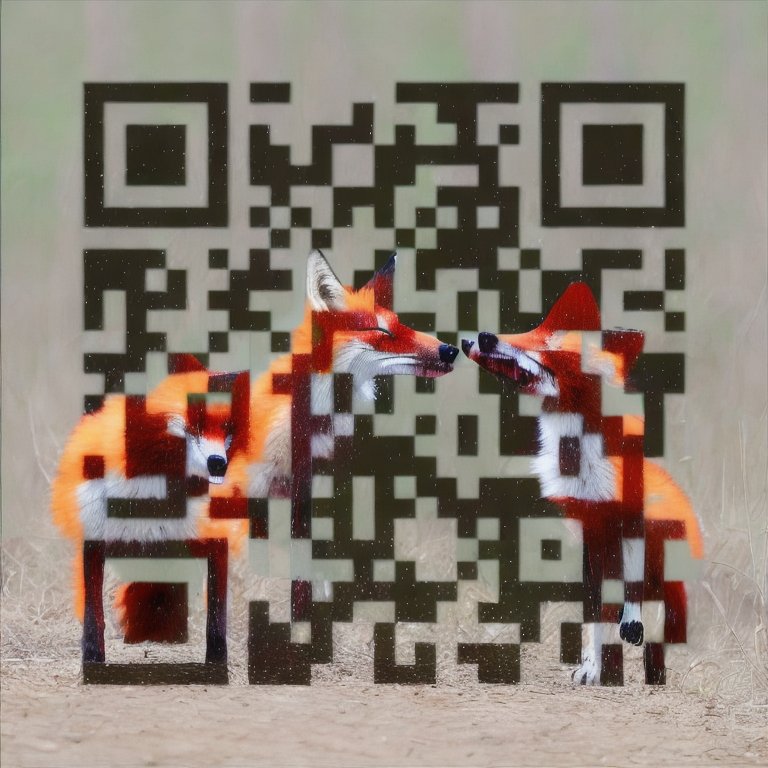

In [ ]:
# example usage: create a qr-code for red fox documentary youtube video

generated_img = model.generate(prompt='red foxes playing in the woods',
                               qr_text='https://www.youtube.com/watch?v=rBc6FExWvrw')

generated_img

  0%|          | 0/30 [00:00<?, ?it/s]

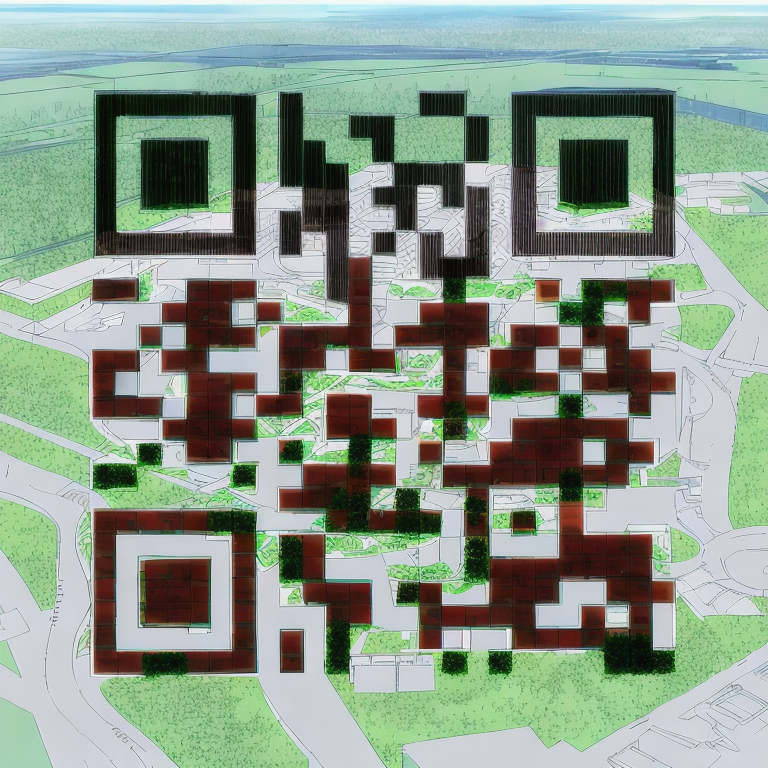

In [ ]:
# another example usage: create a qr-code for innopolis university main site

generated_img_2 = model.generate(prompt='innopolis university new campus design',
                               qr_text='https://innopolis.university')

generated_img_2


## Downscale images so that it can be more easily scannable

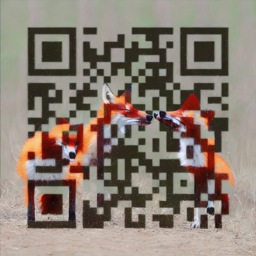

In [ ]:
resized_generated_img = generated_img.resize((256,256))
resized_generated_img

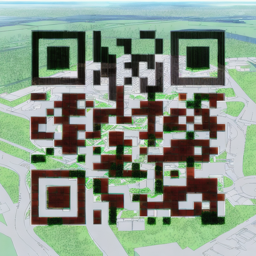

In [ ]:
resized_generated_img_2 = generated_img_2.resize((256,256))
resized_generated_img_2

## Evaluate the results of QR-code AI generation

In [ ]:
BasicQR.read(resized_generated_img)

'https://www.youtube.com/watch?v=rBc6FExWvrw'

In [ ]:
BasicQR.read(resized_generated_img_2)

'https://innopolis.university'

As was obtained, both links read from a given QR-code are valid.

## Create a demo using Gradio visual interface


In [ ]:
demo = gradio.Interface(
    fn=model.generate,
    inputs=["text","text"],
    outputs="image",
    title="QR Code Generator",
    description="Enter the text for which you want to generate a QR code.",
    allow_flagging="never",

)

demo.launch()